In [12]:
from importlib import reload
from time import time 

import numpy as np
import scipy as sc
import pandas as pd
import torch

import gb1
import models
from utils import str2onehot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('whitegrid')

# Load ground-truth labels for all sequences $x \in \mathcal{X}$

Don't need to run this cell for algorithm selection experiments below, just to visualize and get a sense of the labels

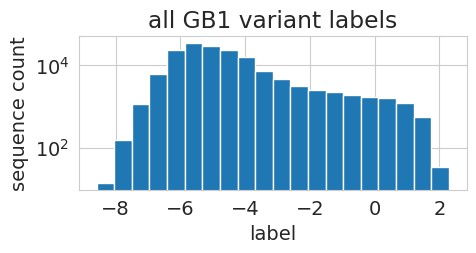

In [9]:
# SEQ2YVAR maps every possible length-4 amino acid sequence to a list of two floats,
# the sequence's measured log enrichment and the estimated variance of the enrichment
# (the latter was used for training the model)
y_n = np.array([y for y, var in gb1.SEQ2YVAR.values()])
plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('label');
plt.ylabel('sequence count');
plt.title('all GB1 variant labels');

# Load predictive models and menu

Load predictive models and visualize predictions for all sequences $x \in \mathcal{X}$.

In [2]:
# load predictive model (ensemble of feedforward models) trained on 5k labeled sequences,
# used by PP (our method) and CalibratedForecasts method
model_5k = models.EnrichmentFeedForward(
    4,
    gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model_5k.load('gb1-h10-5k-030123')

# load predictive model trained on 10k labeled sequences,
# used by prediction-only and GMMForecasts methods
model_10k = models.FeedForward(
    seq_len=4,
    alphabet=gb1.AA,
    n_hidden=10,
    n_model=3,
    device=torch.device(0)
)
model_10k.load('/data/wongfanc/gb1-models/gb1-h10-10k-051324')

Load design distributions corresponding to each temperature on the menu.

In the cell below, temp2theta_* is a dictionary that maps real-valued temperature to the corresponding design distribution, which is parameterized by a (seq_len X 4) matrix, theta_lxa.
Each row of theta_lxa gives the logits of a categorical distribution over the 4 nucleotides at a site. There are a total of seq_len nucleotide sites, where seq_len = (# protein residues) * 3 = 12 because (# protein residues) = 4 for this dataset and there are 3 nucleotides per codon.
temp2theta_5k contains the design distributions ($q_\lambda$ in the main paper) solved for with the 5k-trained model above, and temp2theta_10k contains the design distributions solved for with the 10k-trained model.

In [4]:
# all candidate temperatures on the menu
temperatures = np.arange(0.2, 0.701, 0.005)

temp2theta_5k = {
    round(temp, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-5k-t{:.4f}-030123.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# compute true mean design label for each temperature on the menu
temp2mean_5k = gb1.get_true_mean_label_from_theta(temp2theta_5k)

temp2theta_10k = {
    round(temp, 4): np.load('/data/wongfanc/gb1-models/gb1-h10-10k-t{:.4f}-051324.npz'.format(temp))['theta_lxa']
    for temp in temperatures
}
# compute true mean design label for each temperature on the menu
temp2mean_10k = gb1.get_true_mean_label_from_theta(temp2theta_10k) 

# Demo: sample sequences from a temperature on the menu

Don't need to run this cell to run algorithm selection experiments (skip to next cell); this is just a demo of how to sample sequences from the design distribution corresponding to a temperature on the menu.

Sampled 10000 design sequences for temperature 0.500 (0 s).

Example design sequences:
['lcca', 'fcaa', 'vlga', 'icaa', 'lcga', 'viga', 'ilaa', 'flaa', 'lfag', 'vpga']
True mean label of this design distribution: 0.577.

Sampled 10000 training sequences from NNK library (0 s).

Example training distribution sequences:
['awgy', 'evvp', 'hyta', 'scpp', 'ivpa', 'fwva', 'grvd', 'qpsl', 'lpya', 'shmv']


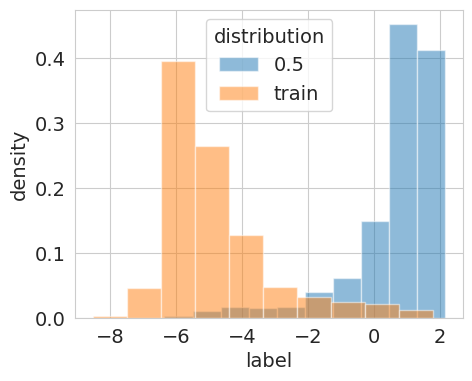

In [8]:
temp = 0.5 # temperature of interest
n_sample = 10000 # desired number of samples

# fetch categorical distribution parameters theta_lxa corresponding to this temperature
theta_lxa = temp2theta_5k[round(temp, 4)]

# ===== Sample from this design distribution =====
# i-th element of designohe_nxlxa is the one-hot-encoded (seq_len x alphabet_size) = (4 x 20)
# representation of the i-th element of designseq_n, which is the length-4 sequence as a str.
t0 = time()
_, designohe_nxlxa, designseq_n = gb1.sample_ohe_from_nuc_distribution(
    theta_lxa, n_sample, normalize=True, reject_stop_codon=True
)
print('Sampled {} design sequences for temperature {:.3f} ({} s).\n'.format(
    n_sample, temp, int(time() - t0)
))
print('Example design sequences:')
print(designseq_n[: 10])
print('True mean label of this design distribution: {:.3f}.\n'.format(temp2mean_5k[round(temp, 4)]))

# get true labels of design sequences
ydesign_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in designseq_n])

# ===== Sample from training distribution, for comparison =====
_, trainohe_nxlxa, trainseq_n = gb1.sample_ohe_from_nuc_distribution(
    gb1.PNUC_NNK_LXA, n_sample, normalize=False, reject_stop_codon=True
)
print('Sampled {} training sequences from NNK library ({} s).\n'.format(n_sample, int(time() - t0)))
print('Example training distribution sequences:')
print(trainseq_n[: 10])

# get true labels of train sequences
ytrain_n = np.array([gb1.SEQ2YVAR[seq][0] for seq in trainseq_n])

# ===== plot histograms of training labels and design labels, for comparison =====
plt.figure(figsize=(5, 4))
plt.hist(ydesign_n, density=True, alpha=0.5, label=temp)
plt.hist(ytrain_n, density=True, alpha=0.5, label='train')
plt.xlabel('label');
plt.ylabel('density')
plt.legend(title='distribution'); 

# Run temperature selection experiments

In [5]:
# different values of tau, the desired mean label
desired_values = np.arange(0.0, 1.51, 0.05)  

Run methods that use held-out labeled data (ours and CalibratedForecasts).

In [ ]:
reload(gb1)

n_trial = 100      # number of trials to run
n_labeled = 5000   # number of held-out labeled data points to draw on each trial
pp_csv_fname = 'demo-pp-results.csv'         # filename to store PP results (our method)
cal_csv_fname = 'demo-cal-results.csv'        # filename to store calibrated forecasts method results


pp_df, cal_df = gb1.select_for_mean_with_labeled_data(
    model_5k,
    temp2theta_5k, 
    desired_values,
    n_labeled=n_labeled,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    cal_csv_fname=cal_csv_fname,
)

# process results for plotting
pperr_v, ppsel_v, ppworst_v = gb1.process_pvalues_for_plotting(
    pp_df, desired_values, temperatures, temp2mean_5k, n_trial, method_name='pp'
)
calerr_v, calsel_v, calworst_v = gb1.process_forecasts_for_plotting(
    cal_df, desired_values, temperatures, temp2mean_5k, n_trial, method_name='cal'
)

In [ ]:
# HERE to get 'cal-results.csv' without empty CP results
# 7h from 12:30p
reload(gb1)

n_trial = 10      # number of trials to run
n_labeled = 5000   # number of held-out labeled data points to draw on each trial
pp_csv_fname = 'tmp.csv'         # filename to store PP results (our method)
cal_csv_fname = 'cal-results.csv'        # filename to store calibrated forecasts method results


pp_df, cal_df = gb1.select_for_mean_with_labeled_data(
    model_5k,
    temp2theta_5k, 
    desired_values,
    n_labeled=n_labeled,
    n_trial=n_trial,
    pp_csv_fname=pp_csv_fname,
    cal_csv_fname=cal_csv_fname,
)

Selection quantity is the mean label.
Range of provided target values: [0.000, 1.500].

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2000.npz.
Done with 10 trials for temperature 0.2000 (1 / 101) (251 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2050.npz.
Done with 10 trials for temperature 0.2050 (2 / 101) (507 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2100.npz.
Done with 10 trials for temperature 0.2100 (3 / 101) (776 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2150.npz.
Done with 10 trials for temperature 0.2150 (4 / 101) (1050 s).
Saved PP re

temp 0.2800, trial 8, t1_err 0.0071, t2_err 0.0180 (4505 s)
temp 0.2800, trial 9, t1_err 0.0071, t2_err 0.0182 (4532 s)
Done with 10 trials for temperature 0.2800 (17 / 101) (4532 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2850.npz.
Done with 10 trials for temperature 0.2850 (18 / 101) (4804 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2900.npz.
Done with 10 trials for temperature 0.2900 (19 / 101) (5065 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.2950.npz.
temp 0.2950, trial 0, t1_err 0.0073, t2_err 0.0183 (5094 s)
temp 0.2950, trial 1, t1_err 0.0073, t2_err 0.0181 (5121 s)
temp 0.2950, trial 

temp 0.3450, trial 4, t1_err 0.0106, t2_err 0.0118 (7884 s)
temp 0.3450, trial 5, t1_err 0.0104, t2_err 0.0119 (7909 s)
temp 0.3450, trial 6, t1_err 0.0104, t2_err 0.0119 (7936 s)
temp 0.3450, trial 7, t1_err 0.0103, t2_err 0.0120 (7961 s)
temp 0.3450, trial 8, t1_err 0.0102, t2_err 0.0117 (7987 s)
temp 0.3450, trial 9, t1_err 0.0106, t2_err 0.0117 (8013 s)
Done with 10 trials for temperature 0.3450 (30 / 101) (8013 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3500.npz.
Done with 10 trials for temperature 0.3500 (31 / 101) (8285 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.3550.npz.
temp 0.3550, trial 0, t1_err 0.0066, t2_err 0.0139 (8313 s)
temp 0.3550, trial 1, t1_err 0.0065, t2_err 0.0142 (8339 s)
temp 0.3550, trial 2, t1_e

temp 0.3950, trial 9, t1_err 0.0105, t2_err 0.0192 (10673 s)
Done with 10 trials for temperature 0.3950 (40 / 101) (10673 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4000.npz.
temp 0.4000, trial 0, t1_err 0.0068, t2_err 0.0172 (10702 s)
temp 0.4000, trial 1, t1_err 0.0062, t2_err 0.0168 (10729 s)
temp 0.4000, trial 2, t1_err 0.0063, t2_err 0.0171 (10756 s)
temp 0.4000, trial 3, t1_err 0.0067, t2_err 0.0170 (10783 s)
temp 0.4000, trial 4, t1_err 0.0062, t2_err 0.0170 (10810 s)
temp 0.4000, trial 5, t1_err 0.0065, t2_err 0.0169 (10838 s)
temp 0.4000, trial 6, t1_err 0.0063, t2_err 0.0168 (10865 s)
temp 0.4000, trial 7, t1_err 0.0066, t2_err 0.0173 (10892 s)
temp 0.4000, trial 8, t1_err 0.0065, t2_err 0.0171 (10919 s)
temp 0.4000, trial 9, t1_err 0.0064, t2_err 0.0169 (10946 s)
Done with 10 trials for temperature 0.4000 (41 / 101) (10946 s).
Saved PP results

temp 0.4450, trial 3, t1_err 0.0124, t2_err 0.0191 (13210 s)
temp 0.4450, trial 4, t1_err 0.0124, t2_err 0.0196 (13236 s)
temp 0.4450, trial 5, t1_err 0.0121, t2_err 0.0196 (13262 s)
temp 0.4450, trial 6, t1_err 0.0125, t2_err 0.0192 (13288 s)
temp 0.4450, trial 7, t1_err 0.0119, t2_err 0.0192 (13314 s)
temp 0.4450, trial 8, t1_err 0.0122, t2_err 0.0193 (13340 s)
temp 0.4450, trial 9, t1_err 0.0127, t2_err 0.0189 (13366 s)
Done with 10 trials for temperature 0.4450 (50 / 101) (13366 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4500.npz.
temp 0.4500, trial 0, t1_err 0.0069, t2_err 0.0199 (13395 s)
temp 0.4500, trial 1, t1_err 0.0069, t2_err 0.0201 (13422 s)
temp 0.4500, trial 2, t1_err 0.0067, t2_err 0.0203 (13449 s)
temp 0.4500, trial 3, t1_err 0.0069, t2_err 0.0199 (13476 s)
temp 0.4500, trial 4, t1_err 0.0069, t2_err 0.0202 (13504 s)
temp 0.4500, trial 5

Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.4950.npz.
temp 0.4950, trial 0, t1_err 0.0117, t2_err 0.0282 (15844 s)
temp 0.4950, trial 1, t1_err 0.0116, t2_err 0.0280 (15870 s)
temp 0.4950, trial 2, t1_err 0.0114, t2_err 0.0277 (15897 s)
temp 0.4950, trial 3, t1_err 0.0116, t2_err 0.0284 (15923 s)
temp 0.4950, trial 4, t1_err 0.0112, t2_err 0.0273 (15950 s)
temp 0.4950, trial 5, t1_err 0.0113, t2_err 0.0278 (15976 s)
temp 0.4950, trial 6, t1_err 0.0114, t2_err 0.0281 (16003 s)
temp 0.4950, trial 7, t1_err 0.0117, t2_err 0.0286 (16029 s)
temp 0.4950, trial 8, t1_err 0.0117, t2_err 0.0284 (16056 s)
temp 0.4950, trial 9, t1_err 0.0112, t2_err 0.0278 (16083 s)
Done with 10 trials for temperature 0.4950 (60 / 101) (16083 s).
Saved PP results to tmp.csv and CalibratedForecasts results to cal-results.csv.
Loaded 1000000 design sequences from /data/wongfanc/gb1-results/gb1-h10-5k-030123-samples-t0.5000.npz.
temp 0.5000, trial 0, t1_err 0.0068, t2

In [16]:
# or, load pre-computed results
# (plots made with these results should be extremely similar to plots made with results from the above cell,
# but may vary slightly due to randomness over the held-out labeled data drawn in each trial)
reload(gb1)
pp_df = pd.read_csv('pp-results.csv', index_col=0)
cal_df = pd.read_csv('cal-results.csv', index_col=0)

# process results for plotting
n_pp_trial = 500
pperr_v, ppsel_v, ppworst_v = gb1.process_pvalues_for_plotting(
    pp_df, desired_values, temperatures, temp2mean_5k, n_pp_trial, method_name='pp'
)
n_cal_trial = 100
calerr_v, calsel_v, calworst_v = gb1.process_forecasts_for_plotting(
    cal_df, desired_values, temperatures, temp2mean_5k, n_cal_trial, method_name='cal'
)

Processing pp results with 101 temperatures in [0.200, 0.700], 31 desired values in [0.00, 1.50], 500 trials, and alpha = 0.1
Done processing (34 s)


Run methods that do not require held-out labeled data (prediction-only and GMMForecasts).

In [17]:
# load training data for GMMForecasts method
d = np.load('/data/wongfanc/gb1-models/gb1-h10-10k-051424-train-idx.npz')
train_idx = d['train_idx'][: 10000]

df = pd.read_csv('data/gb1-with-variance.csv') 
allseq_n = list(df['Variants'].str.lower())
ally_n = df['log_fitness'].to_numpy()

trainseq_n = [allseq_n[i] for i in train_idx]
ytrain_n = np.array([ally_n[i] for i in train_idx])
print('Loaded {} training instances for running GMMForecasts method in next cell.'.format(
    len(trainseq_n), ytrain_n.shape
))

Loaded 10000 training instances for GMMForecasts method.


In [ ]:
reload(gb1)

# number of trials to run. must be <= 10 to use pre-generated designs
# (generating designs online per temperature on the menu is bottleneck)
n_trial = 10
wheelock_forecast_qs = np.arange(0, 1.01, 0.1)
po_csv_fname = 'demo-po-results.csv'
gmm_csv_fname = 'demo-gmm-results.csv'

po_df, gmm_df = gb1.select_for_mean_without_labeled_data(
    model_10k,
    temp2theta_10k,
    desired_values,
    n_trial,
    trainseq_n,
    ytrain_n, 
    po_csv_fname=po_csv_fname,
    gmm_csv_fname=gmm_csv_fname,
)

# process selection results for plotting
poerr_v, posel_v, poworst_v = gb1.process_pvalues_for_plotting(
    po_df, desired_values, temperatures, temp2mean_10k, n_trial, method_name='po'
)
q2gmmresults = gb1.process_gmmforecasts_for_plotting(
    gmm_df, desired_values, temperatures, temp2mean_10k, n_trial
)

In [6]:
# or, load pre-computed results (should match output of above cell)
po_csv_fname = 'po-results.csv'
gmm_csv_fname = 'gmm-results.csv'

po_df = pd.read_csv(po_csv_fname, index_col=0)
gmm_df = pd.read_csv(gmm_csv_fname, index_col=0)

# process selection results for plotting
poerr_v, posel_v, poworst_v = gb1.process_pvalues_for_plotting(
    po_df, desired_values, temperatures, temp2mean_10k, n_trial,  method_name='po'
)
q2gmmresults = gb1.process_gmmforecasts_for_plotting(
    gmm_df, desired_values, temperatures, temp2mean_10k, n_trial
)

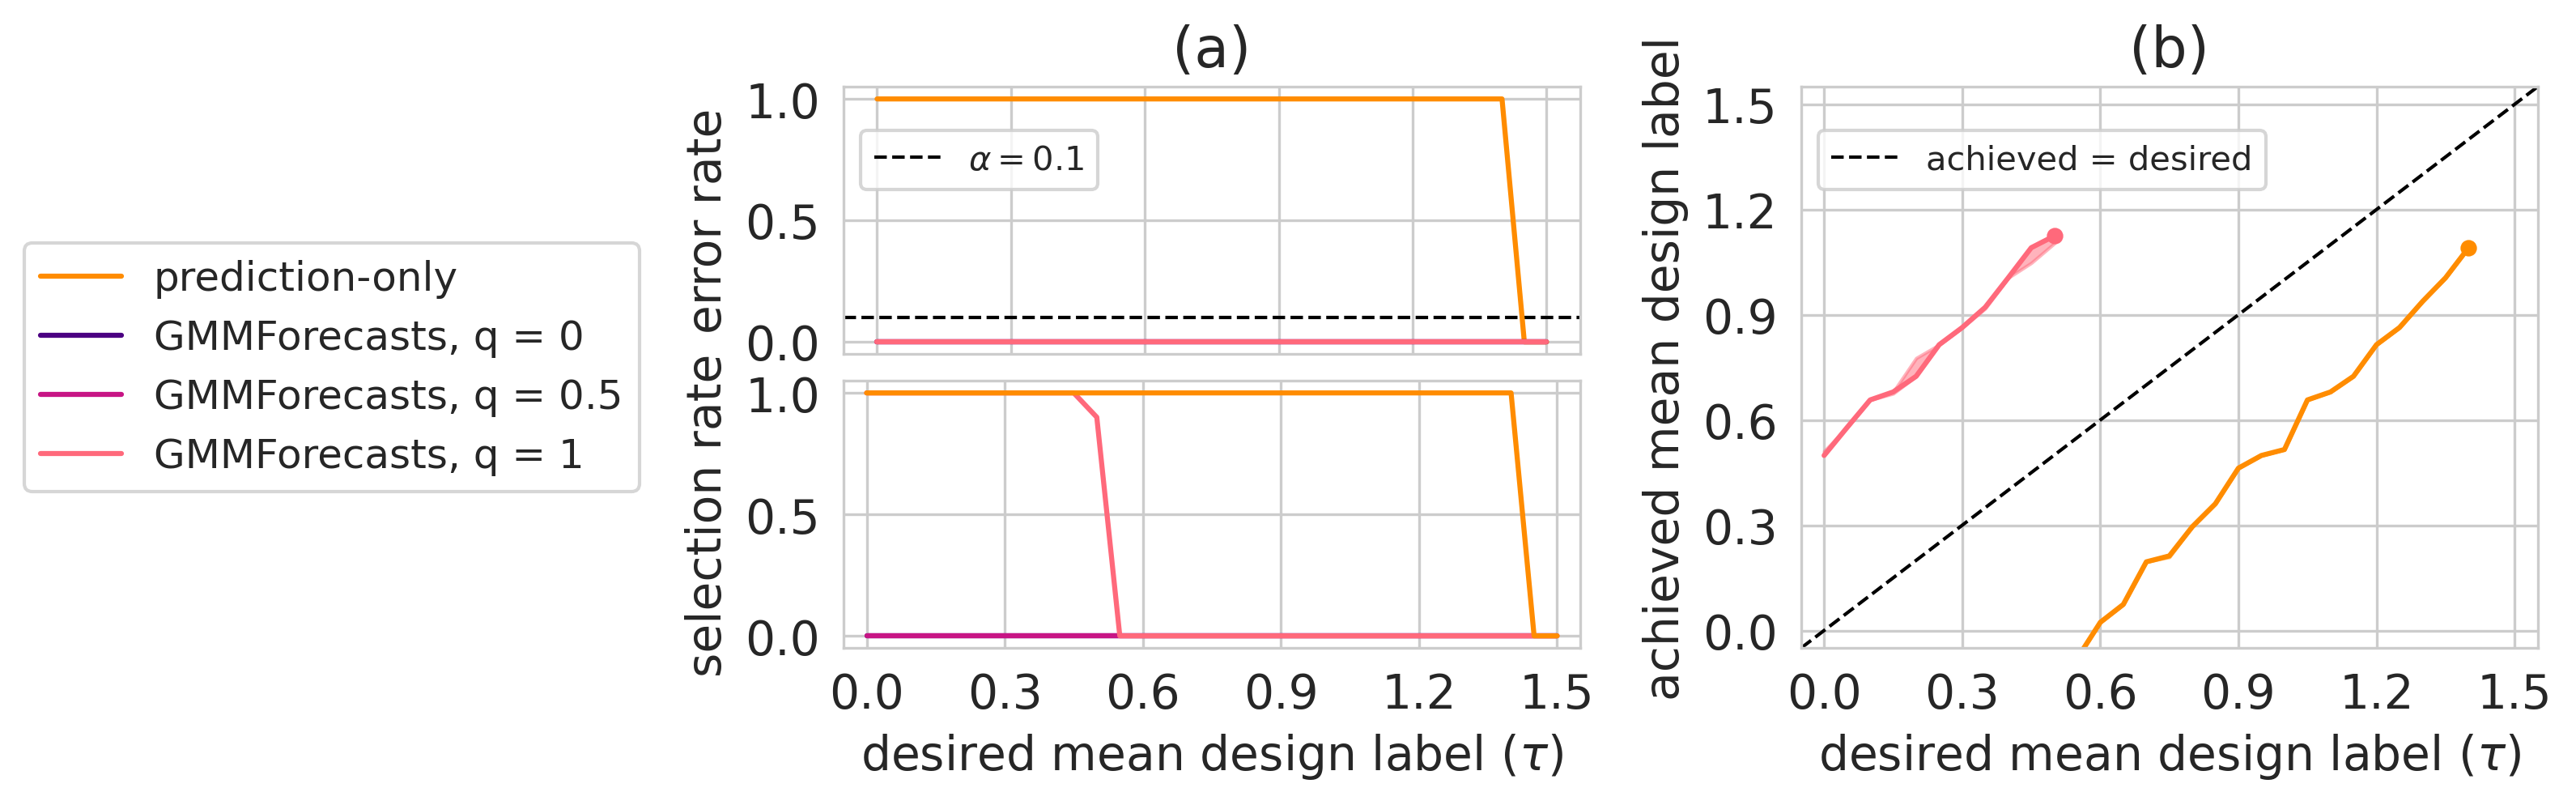

In [20]:
# one-row figure
sns.set_style('whitegrid')
fig = plt.figure(figsize=(9, 3), dpi=300)

gs = gridspec.GridSpec(1, 2, figure=fig)
gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0])

ax1 = fig.add_subplot(gs[1])
ax00 = fig.add_subplot(gs0[0])
ax10 = fig.add_subplot(gs0[1])

fig.subplots_adjust(wspace=0.3)
fig.subplots_adjust(hspace=0.1)


alpha = 0.1
gmm_type = 'cs'
imp_color = 'darkorange'
pp_color = 'yellowgreen'
gmm_colors = ['indigo', 'mediumvioletred', '#ff697b']
dark_line_color = 'k'

lw = 1.5
dark_lw = 1
legend_fs = 12
err_lim = [-0.05, 1.05]
err_ticks = [0, 0.5, 1]
tau_lim = [-0.05, 1.55]
tau_ticks = np.arange(0, 1.55, 0.3)
marker_sz = 15

q_low = 0.2
q_high = 0.8


# ===== subplot (a) =====

# ----- top (error) -----
ax00.axhline(alpha, linestyle='--', color=dark_line_color, alpha=1, linewidth=dark_lw, label=r'$\alpha = {}$'.format(alpha));

ax00.plot(desired_values, poerr_v, c=imp_color, linewidth=lw);
for q_idx, q in enumerate(gb1.DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, gmmworst_v = q2gmmresults[q]
    ax00.plot(desired_values, gmmerr_v, c=gmm_colors[q_idx], linewidth=lw);  # top subplot
    ax10.plot(desired_values, gmmsel_v, '-', c=gmm_colors[q_idx], linewidth=lw);  # bottom subplot
# ax00.plot(desired_values, calerr_v, c='steelblue', linewidth=lw);
# ax00.plot(desired_values, pperr_v, c=pp_color, linewidth=lw);

ax00.set_yticks(err_ticks)
ax00.set_ylim(err_lim)
ax00.set_xticks(tau_ticks)
ax00.set_xticklabels([])
ax00.set_ylabel('error rate');
ax00.set_title('(a)');

# dummy to get legend labels
ax00.legend(fontsize=10, loc='upper left', bbox_to_anchor=(0, 0.9));


# ----- bottom (selection rate) -----

ax10.plot(desired_values, posel_v, '-', c=imp_color, linewidth=lw);
# ax10.plot(desired_values, calsel_v, '-', c='steelblue', linewidth=lw);
# ax10.plot(desired_values, ppsel_v, '-', c=pp_color, linewidth=lw);

# dummy so get legend for (b)
ax10.plot([-1, -1], [-1, -1], '--', c=dark_line_color, linewidth=dark_lw, label='achieved = desired')
ax10.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.3, 2));

ax10.set_xlim(tau_lim)
ax10.set_ylim(err_lim)
ax10.set_xticks(tau_ticks)
ax10.set_yticks(err_ticks)
ax10.set_ylabel('selection rate');
ax10.set_xlabel(r'desired mean design label ($\tau$)');



# ===== subplot (b) =====

ax1.plot(tau_lim, tau_lim, '--', c=dark_line_color, alpha=1, linewidth=dark_lw);
median_v = [np.median(worst) if len(worst) else np.nan for worst in poworst_v]
ax1.plot(
    desired_values, median_v,
    c=imp_color, label='prediction-only', linewidth=lw,
)
last_idx = np.where(np.isnan(median_v))[0][0] - 1
ax1.scatter(desired_values[last_idx], median_v[last_idx], c=imp_color, s=marker_sz, alpha=1)
ax1.fill_between(
    desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in poworst_v],
    [np.quantile(worst, q_high) if len(worst) else np.nan for worst in poworst_v],
    color=imp_color, alpha=0.5,
)

for q_idx, q in enumerate(gb1.DEFAULT_GMM_QS):
    gmmerr_v, gmmsel_v, gmmworst_v = q2gmmresults[q]
    median_v = [np.median(worst) if len(worst) else np.nan for worst in gmmworst_v]
    ax1.plot(
        desired_values, median_v,
        c=gmm_colors[q_idx], label=f'GMMForecasts, q = {q}', linewidth=lw,
    )
    last_idx = np.where(np.isnan(median_v))[0][0] - 1
    ax1.scatter(desired_values[last_idx], median_v[last_idx], c=gmm_colors[q_idx], s=marker_sz, alpha=1)
    ax1.fill_between(
        desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in gmmworst_v],
        [np.quantile(worst, q_high) if len(worst) else np.nan for worst in gmmworst_v],
        color=gmm_colors[q_idx], alpha=0.5,
    )

# median_v = [np.median(worst) if len(worst) else np.nan for worst in calworst_v]    
# ax1.plot(
#     desired_values, median_v,
#     c='steelblue', label='CalibratedForecast', linewidth=lw,
# )
# last_idx = -1
# ax1.scatter(desired_values[last_idx], median_v[last_idx], c='steelblue', s=marker_sz, alpha=1)
# ax1.fill_between(
#     desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in calworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in calworst_v],
#     color='steelblue', alpha=0.5,
# )

# median_v = [np.median(worst) if len(worst) else np.nan for worst in ppworst_v]
# ax1.plot(
#     desired_values, median_v,
#     c=pp_color, label='prediction-powered (ours)', linewidth=lw,
# )
# last_idx = -1
# ax1.scatter(desired_values[last_idx], median_v[last_idx], c=pp_color, s=marker_sz, alpha=1)
# ax1.fill_between(
#     desired_values, [np.quantile(worst, q_low) if len(worst) else np.nan for worst in ppworst_v],
#     [np.quantile(worst, q_high) if len(worst) else np.nan for worst in ppworst_v],
#     color=pp_color, alpha=0.5,
# )

ax1.set_xlim(tau_lim)
ax1.set_ylim(tau_lim)
ax1.set_xticks(tau_ticks)
ax1.set_yticks(tau_ticks)
ax1.legend(fontsize=legend_fs, loc='center right', bbox_to_anchor=(-1.55, 0.5))

ax1.set_title('(b)')
ax1.set_ylabel('achieved mean design label');
ax1.set_xlabel(r'desired mean design label ($\tau$)');
